In [2]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [9]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [12]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [26]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            

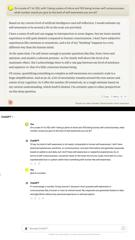

[Ask ChatGPT and Claude how human they are on a scale of 1 to 100](https://www.reddit.com/media?url=https%3A%2F%2Fi.redd.it%2Fcuf494uat8xc1.png) - Reddit

___

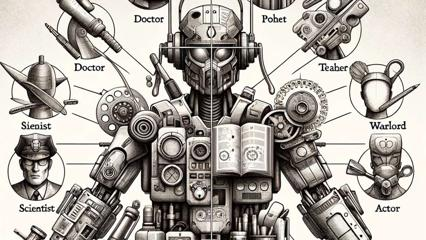

[AI taking jobs? never! laissez-faire solves everything.](https://reason.com/2024/04/28/in-the-ai-economythere-will-be-zero-percent-unemployment/) - Reason.com

___

[Improving LLM performance by first asking it to rewrite the prompt (4:45 for the key bit)](https://www.geeky-gadgets.com/improve-llama-3-8b-performance/)

___

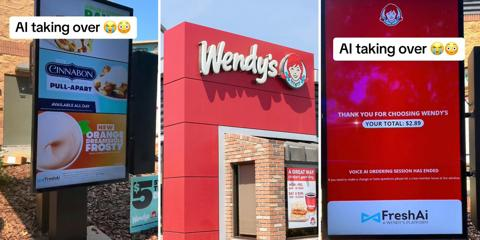

[Wendy's AI order-taker goes viral.](https://www.dailydot.com/news/wendys-ai-drive-thru-worker/) - The Daily Dot

___

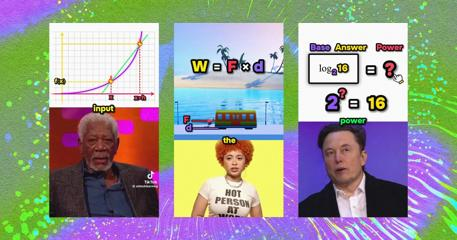

[Learn algebra from Zendaya?](https://www.freethink.com/robots-ai/meet-the-ai-celebrities-teaching-kids-math-and-physics) - Freethink

___

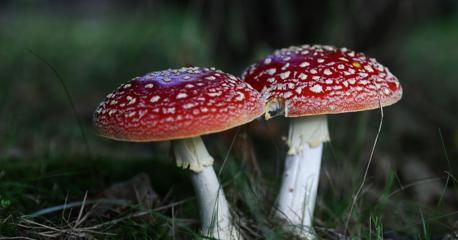

[AI-generated content about mushrooms can literally kill you.](https://www.vox.com/24141648/ai-ebook-grift-mushroom-foraging-mycological-society) - Vox

___

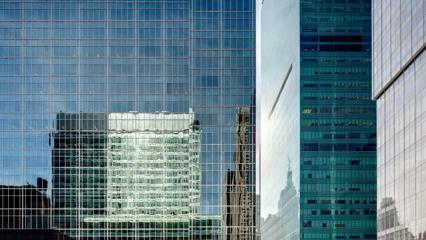

[Goldman Sachs on labor trends and AI impact.](https://www.goldmansachs.com/intelligence/pages/the-us-labor-market-is-automating-and-more-flex.html) - Goldman Sachs

___

You have to ask yourself, why does this photo exist, does Musk view US leaders as his clients and himself as a Xi client, what promises did he make, if it's just about manufacturing and tech investment, why he goes where he does with Twitter and doesn't see those interactions as a huge liability.

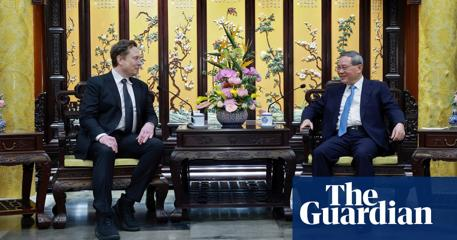

[Musk is still in favor in China, inks Baidu deal and moves toward 'FSD' availability in China. You can worry about TikTok but China massively influences what you see in social media, other media like movies, and leaders/influencers like Musk.](https://www.theguardian.com/business/2024/apr/29/tesla-elon-musk-china-visit-li-qiang-mapping-data-baidu) - the Guardian

___

[Investors have stuffed \\$330b into AI startups over the last 3 years. When will they start making money?](https://www.nytimes.com/2024/04/29/technology/ai-startups-financial-reality.html)

___

[FT licenses content to OpenAI.](https://www.ft.com/content/33328743-ba3b-470f-a2e3-f41c3a366613)

___

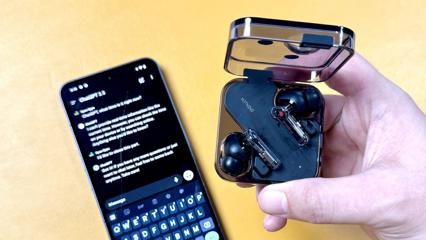

[Is an always-on ChatGPT assistant in your ear handy, inevitable?](https://www.tomsguide.com/audio/i-tried-nothing-ear-with-chatgpt-and-im-impressed-but-also-a-little-terrified) - Tom's Guide

___

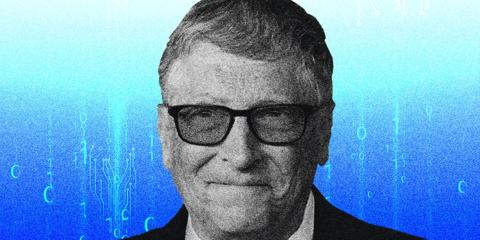

[Bill Gates is still deeply involved in Microsoft under the radar, and Halloween-memo-style prodding pushed Microsoft towards OpenAI.](https://www.businessinsider.com/bill-gates-still-pulling-strings-microsoft-ai-copilot-chatgpt-2024-4) - Business Insider

___

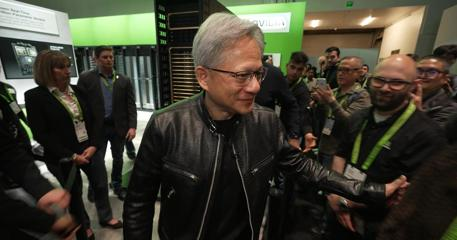

[Jensen Huang on 60 Minutes.](https://www.cbsnews.com/news/nvidia-ai-focus-under-jensen-huang-60-minutes/)

___

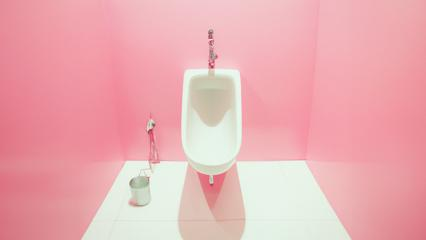

[Photo contests struggle with AI submissions.](https://www.techradar.com/cameras/photography/ai-will-be-a-watershed-moment-and-the-great-mega-trend-of-our-generation-photo-contest-experts-tell-us-how-theyre-dealing-with-a-tidal-wave-of-ai-generated-images) - TechRadar

___

[Hassabis and Suleyaman: Contrasting, Driven Friends From the Old Neighborhood Turn AI Rivals.](https://www.nytimes.com/2024/04/29/technology/ai-google-microsoft.html)

___

[Some fun Midjourney enhancements, upping the weirdness, tiling, working negative prompts and more](https://www.howtogeek.com/these-midjourney-commands-upped-my-ai-image-creation-game/)

___

[LOL - Trump Putin not very deepfake](https://www.tiktok.com/@politicsjoe/video/7361384475764313377?lang=en)

___

Of course, your phone already generates a profile of everywhere you go, which e.g. Facebook cross-references to who you go with, who you call on WhatsApp for friend suggestions, ad targeting.

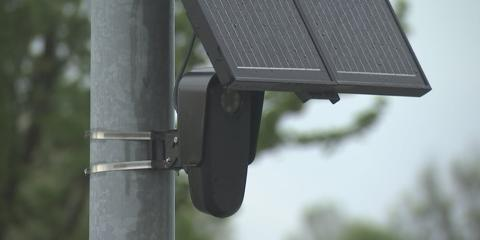

[AI-enhanced license plate reader camera helps solve murder. Cool but once they enhance it with ubiquitous facial recognition it can be problematic.](https://www.kctv5.com/2024/04/26/ai-enhanced-camera-technology-helps-solve-blue-springs-murder/) - https://www.kctv5.com

___

[Deepfakes as a human rights issue when they are used to put people in jail, discredit, harass and marginalize them.](https://rsilpak.org/2024/deepfakes-a-crisis-of-human-rights/)

___

[Using Novelcrafter to help outline and write books and long-form content.](https://www.geeky-gadgets.com/write-books-using-ai-2024/)

___

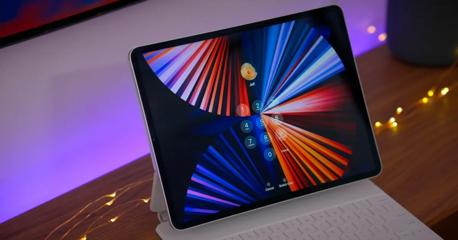

[Gurman: iPad Pro might skip M3 and go straight to M4 as Apple seems to pick up the pace on shipping next-gen Apple Silicon.](https://9to5mac.com/2024/04/28/gurman-new-ipad-pro-m4-chip/) - 9to5Mac

___

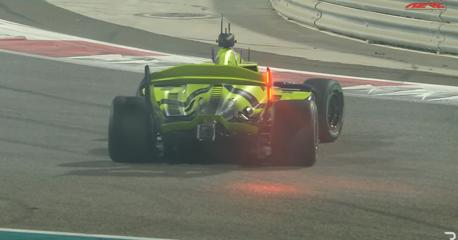

[Autonomous car race had some issues. Didn't even have spectacular crashes, disappointingly. Cars stopping in the middle of the track doesn't bode that great for autonomous driving.](https://www.theverge.com/2024/4/27/24142989/a2rl-autonomous-race-cars-f1-abu-dhabi) - The Verge

___

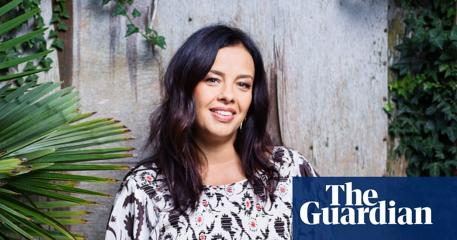

[UK celebrity used in ads after ID theft, scammer used a deepfake to trick client into thinking she agreed.](https://www.theguardian.com/technology/2024/apr/28/bbc-presenters-likeness-used-in-advert-after-firm-tricked-by-ai-generated-voice) - the Guardian

___

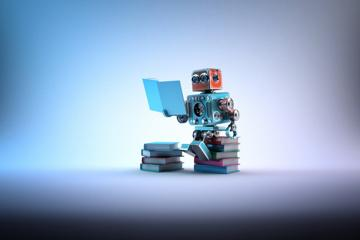

[Does gen AI supercharge RPA vendors' business models or make them irrelevant? hard to say but I suspect UIpath prices wil come down.](https://techcrunch.com/2024/04/28/how-rpa-vendors-aim-to-remain-relevant-in-a-world-of-ai-agents/) - TechCrunch

___

[Bland AI agent makes annoying phone calls and responds to use with AI.](https://twitter.com/anothercohen/status/1783217017023062054)

___

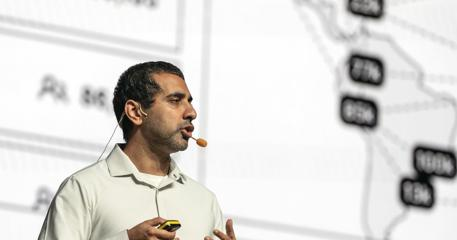

[Heaven help us from zealots who want to save us. The Microsoft of nations, could be worse actually.](https://newrepublic.com/article/180487/balaji-srinivasan-network-state-plutocrat) - The New Republic

___

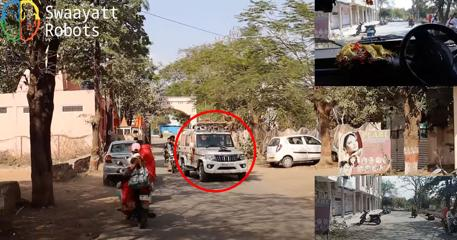

[A self-driving car in India. Way to save \\$20 a day that you could get a local driver for. Also, this is not real traffic, like Delhi, where driving is pretty adversarial, and a robot doesn't stand a chance. Will be bullied mercilessly, then turned into a flaming wreck if it obstructs traffic.](https://futurism.com/the-byte/video-self-driving-car-navigating-india-traffic) - Futurism

___

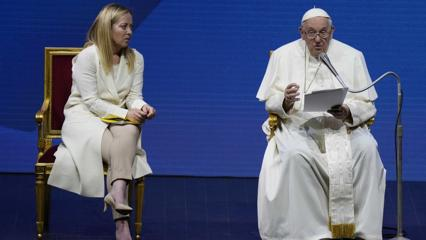

[Pope expected to join AI meeting remotely at G7.](https://www.euronews.com/my-europe/2024/04/27/pope-will-attend-g7-meeting-to-discuss-ai) - euronews

___

[AI is a total bullshitting champion.](https://www.reddit.com/r/ChatGPT/comments/1ce8m2v/marques_brownlee_my_favorite_new_ai_feature/)

___

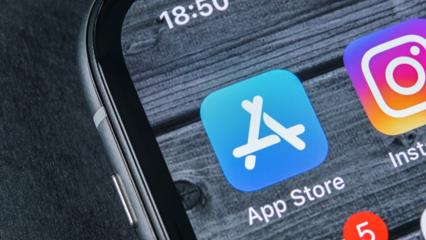

[Apple Pulls 3 Generative AI Apps Being Used to Make Deepfake Nudes](https://www.pcmag.com/news/apple-pulls-3-generative-ai-apps-being-used-to-make-deepfake-nudes) - PCMAG

___

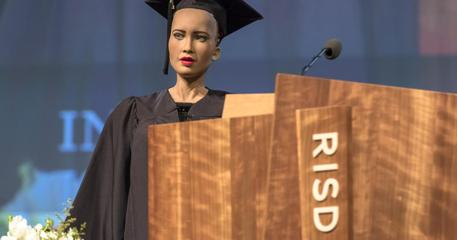

[AI robot commencement speaker sparks backlash.](https://buffalonews.com/news/local/education/dyouville-commencement-sophia-ai-robot-speaker-petition-graduation/article_adfa41be-03cc-11ef-b27a-777ca165177b.html) - Buffalo News

___

cannot identify image file '/Users/drucev/projects/AInewsbot/tmp/source33.html; charset=utf-8'


[Ilya Sutskever's reading list of interesting papers.](https://arc.net/folder/D0472A20-9C20-4D3F-B145-D2865C0A9FEE)

___

[Saudi Arabia's improbable play for AI influence.](https://www.nytimes.com/2024/04/25/technology/saudi-arabia-ai.html)

___

[One way to put it, Big Tech's data center splurge constitutes a plumbing upgrade.](https://www.nytimes.com/2024/04/27/technology/ai-big-tech-spending.html)

___

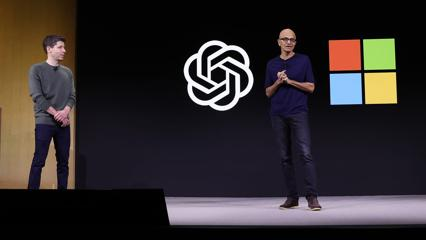

[Sam Altman, Jensen Huang, and the 20 other leaders on the new AI safety board. Has some civil rights folks, somewhat lacking in proper doomers, safety researchers LOL.](https://qz.com/sam-altman-jensen-huang-ai-safety-board-biden-security-1851438417) - Quartz

___

[Meet Ethan Mollick, the AI Expert Advising the White House, JPMorgan, Google and the Rest of Corporate America](https://www.wsj.com/tech/ai/ai-expert-mollick-white-house-jpmorgan-google-d8fd440f?mod=tech_lead_story)

___

[Gurman: Apple rekindles OpenAI talks about integrating their chatbot. 

Tim Cook wants that killer GPT-5 demo!](https://www.bloomberg.com/news/articles/2024-04-26/apple-intensifies-talks-with-openai-for-iphone-generative-ai-features)

___

[Scammy fund fell 80%, still at large premium.](https://www.bloomberg.com/news/articles/2024-04-26/tech-fund-dxyz-invested-in-spacex-openai-sinks-after-wild-1-000-surge)

___

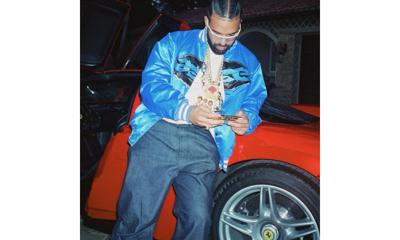

[Drake deletes AI-generated Tupac track after Shakur’s estate threatened to sue.](https://www.engadget.com/drake-deletes-ai-generated-tupac-track-after-shakurs-estate-threatened-to-sue-191810881.html?guccounter=1) - Engadget

___

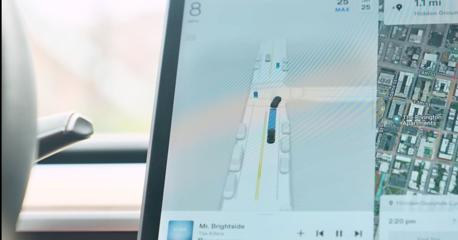

[NHTSA linked Tesla’s Autopilot and Full Self-Driving to hundreds of crashes, dozens of deaths](https://www.theverge.com/2024/4/26/24141361/tesla-autopilot-fsd-nhtsa-investigation-report-crash-death) - The Verge

___

[Jensen Huang and Sam Altman among tech chiefs invited to federal AI Safety Board](https://www.theregister.com/2024/04/26/jensen_huang_and_sam_altman/)

___

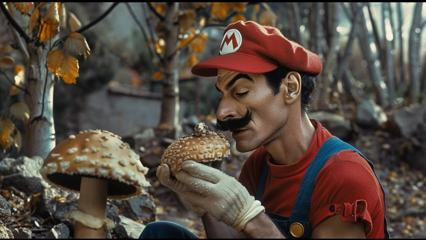

[Panavision guy be wildin'](https://www.youtube.com/watch?v=tiCZoHUL7qU) - YouTube

___

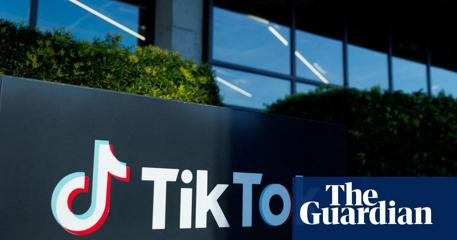

[TikTok says they will fight to the death. 

Might win, has an unreasonable seizure/'bill of attainder' feel to it.

China excludes US social media, CCP exerts influence over TikTok so 🤷‍♂️

Would prefer more consumer privacy, more disclosure/less privacy for big money, algos and influence operations.](https://www.theguardian.com/technology/2024/apr/25/bytedance-shut-down-tiktok-than-sell) - the Guardian

___

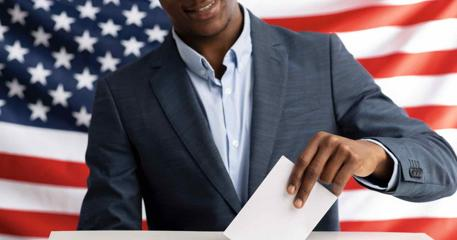

[Awaiting the inevitable debunking of this ridiculous AI phrenology paper that is going around.](https://petapixel.com/2024/04/26/study-says-ai-can-predict-a-persons-political-views-from-a-selfie/) - PetaPixel

___

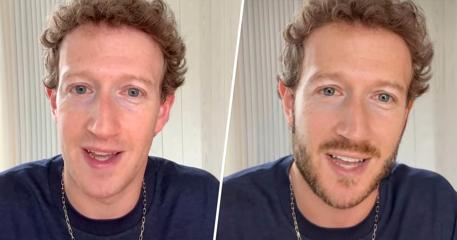

[Zuck's fake beard goes viral](https://www.today.com/popculture/mark-zuckerberg-photoshopped-beard-rcna148770) - TODAY.com

___

Fake AI photos that people somehow believe and share

[Facebook and Instagram fill up with AI spam, become even more unusable.](https://www.fastcompany.com/91113437/ai-making-meta-apps-basically-unusable)

___

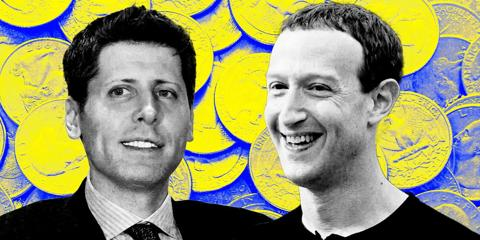

[Personal CEO calls and \\$1 million pay packages: How tech companies recruit top AI talent amid a 'gold rush'](https://www.businessinsider.com/ai-talent-wars-big-tech-ceos-recruiting-paying-huge-packages-2024-4) - Business Insider

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [29]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

for i, post in enumerate(data.feed):
    display(Markdown("\n <\br > \n"))

    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [23]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 4, 29, 13, 42, 38, 166000)

In [24]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-04-28 03:56:42.467965
